<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/feature_importance_history.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== MLP with ReLU/Linear Activations Demo ===
Data shape: (1000, 4), Training: 800, Test: 200

=== All ReLU ===
Input: 4 features
Hidden 1: 64 units -> RELU
Hidden 2: 32 units -> RELU
Hidden 3: 16 units -> RELU
Output: 1 (linear)
Epoch    0, Loss: 3.246871
Epoch  100, Loss: 0.014670
Epoch  200, Loss: 0.006209
Epoch  300, Loss: 0.004118
Final Loss: 0.003307
Train - MSE: 0.003302, R²: 0.9991
Test  - MSE: 0.005386, R²: 0.9985


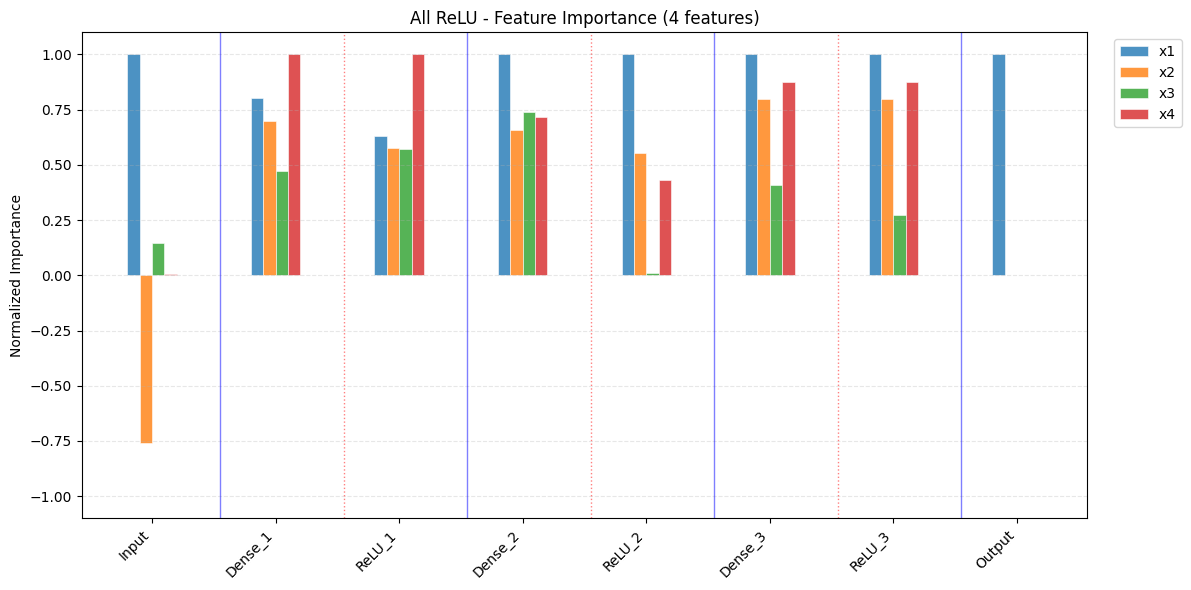


=== Mixed ReLU/Linear ===
Input: 4 features
Hidden 1: 48 units -> RELU
Hidden 2: 24 units -> LINEAR
Hidden 3: 12 units -> RELU
Output: 1 (linear)
Epoch    0, Loss: 4.298784
Epoch  100, Loss: 0.032789
Epoch  200, Loss: 0.011438
Epoch  300, Loss: 0.007616
Final Loss: 0.005766
Train - MSE: 0.005751, R²: 0.9984
Test  - MSE: 0.008101, R²: 0.9977


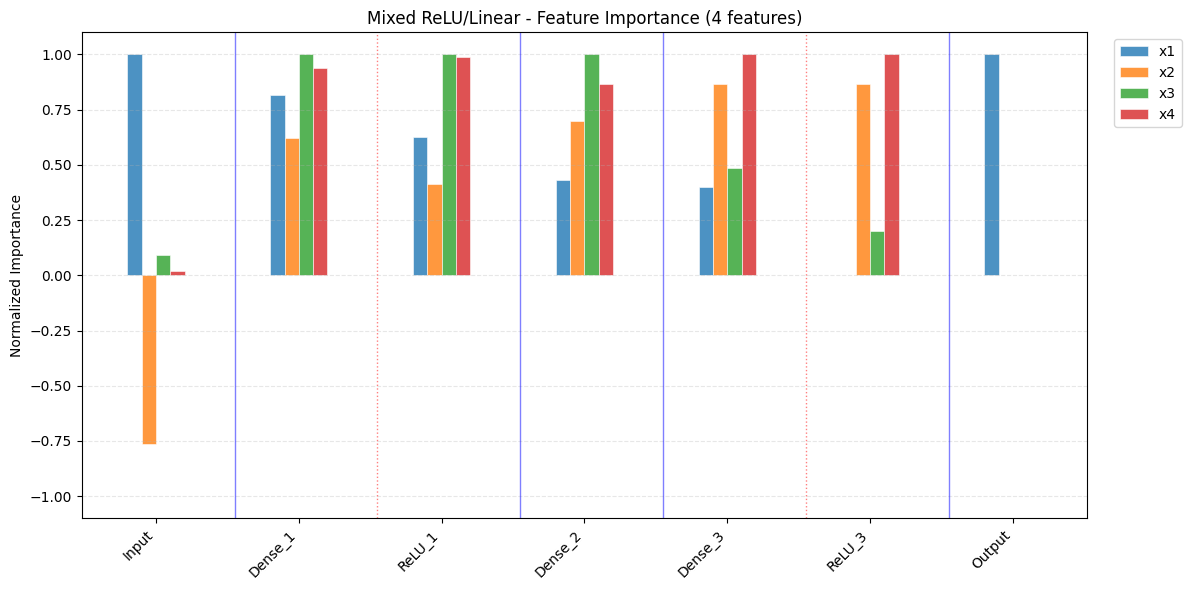


=== All Linear ===
Input: 4 features
Hidden 1: 32 units -> LINEAR
Hidden 2: 16 units -> LINEAR
Output: 1 (linear)
Epoch    0, Loss: 3.916614
Epoch  100, Loss: 0.034056
Epoch  200, Loss: 0.033864
Epoch  300, Loss: 0.033864
Final Loss: 0.033864
Train - MSE: 0.033864, R²: 0.9904
Test  - MSE: 0.039077, R²: 0.9889


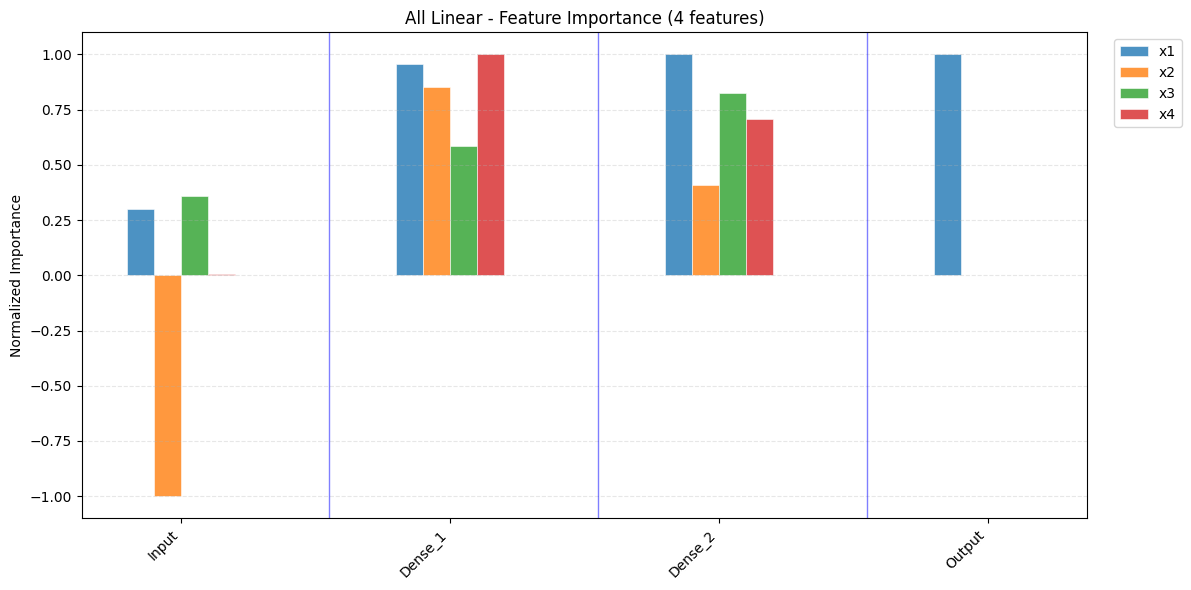


=== Deep ReLU ===
Input: 4 features
Hidden 1: 128 units -> RELU
Hidden 2: 64 units -> RELU
Hidden 3: 32 units -> RELU
Hidden 4: 16 units -> RELU
Hidden 5: 8 units -> RELU
Dropout: 0.1
Output: 1 (linear)
Epoch    0, Loss: 3.528292
Epoch  100, Loss: 0.440213
Epoch  200, Loss: 0.268884
Epoch  300, Loss: 0.235552
Final Loss: 0.194553
Train - MSE: 0.057930, R²: 0.9835
Test  - MSE: 0.057628, R²: 0.9836


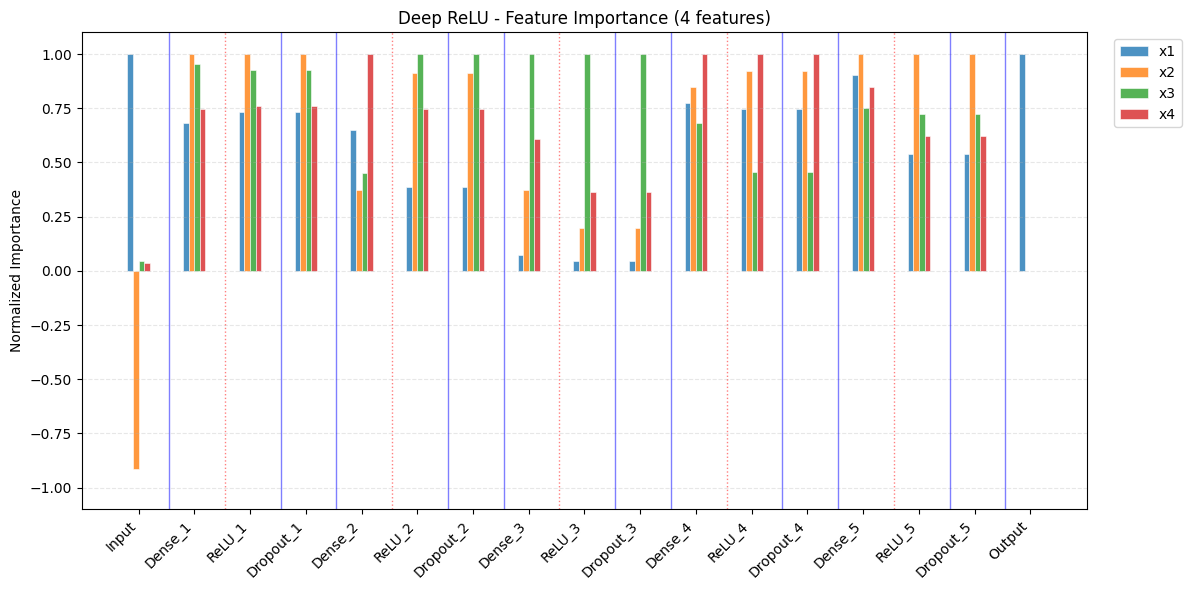


=== Performance Summary ===
All ReLU             - Test MSE: 0.005386, Test R²: 0.9985
Mixed ReLU/Linear    - Test MSE: 0.008101, Test R²: 0.9977
All Linear           - Test MSE: 0.039077, Test R²: 0.9889
Deep ReLU            - Test MSE: 0.057628, Test R²: 0.9836


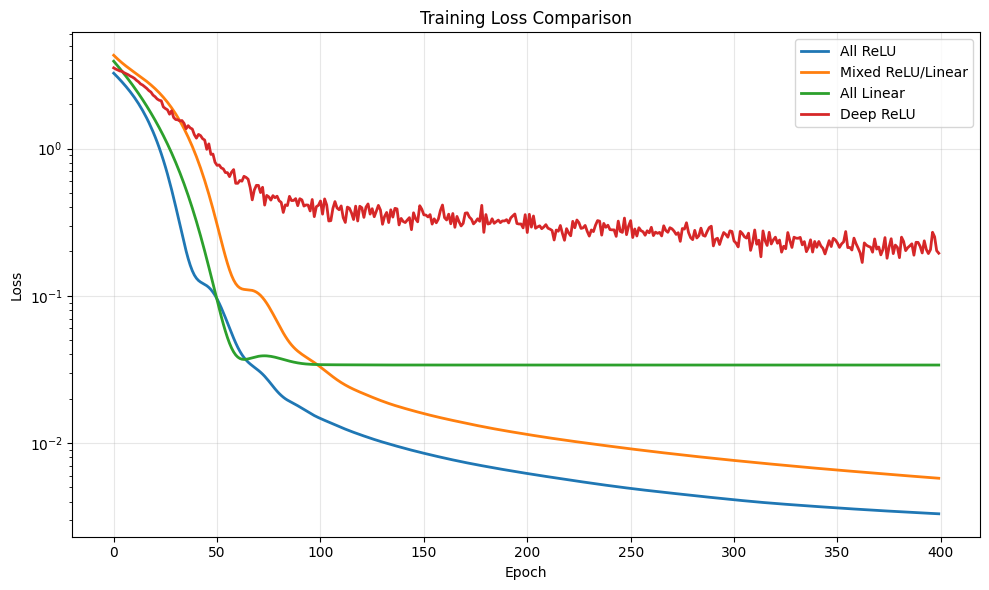

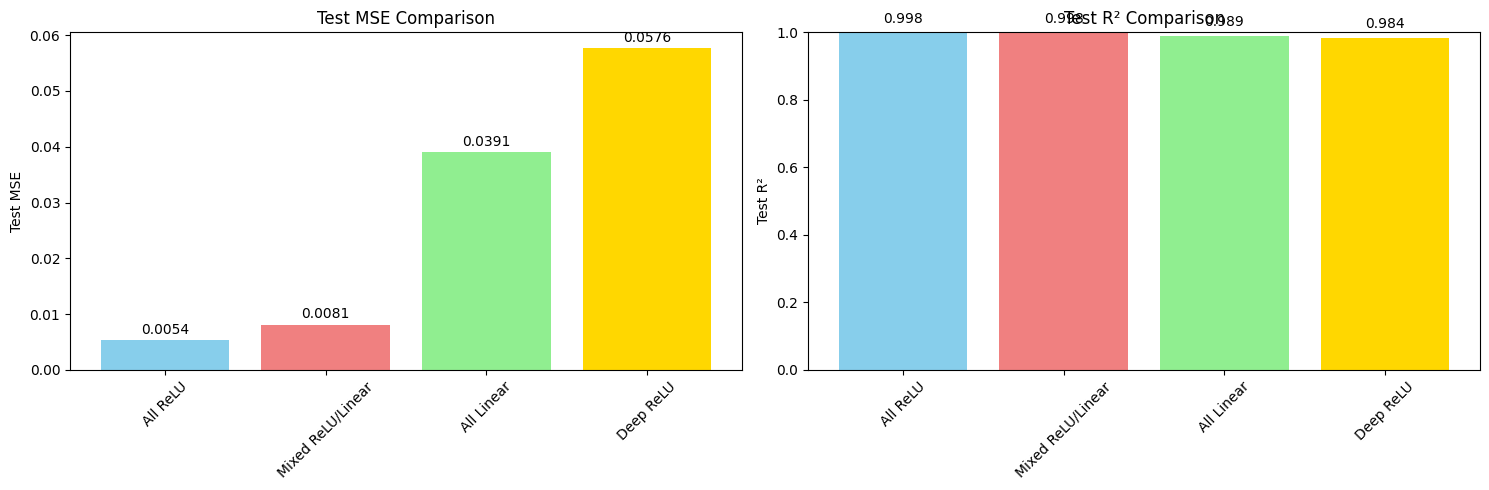


Best MSE: All ReLU (0.005386)
Best R²:  All ReLU (0.9985)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
from typing import List, Optional, Union, Iterator, Dict, Any, Callable, Protocol
from abc import ABC, abstractmethod
from functools import partial
from itertools import chain


@dataclass
class MLPConfig:
    """Configuration for MLP architecture with ReLU/Linear activations only."""
    input_dim: int
    hidden_units: List[int]
    output_dim: int = 1
    activation: Union[str, List[str]] = "relu"
    use_bias: bool = True
    dropout_rate: Optional[float] = None

    def __post_init__(self):
        """Validate and process activation configuration."""
        valid_activations = {"relu", "linear"}

        # 3중 조건문으로 activation 처리
        self.activations = (
            [self.activation.lower()] * len(self.hidden_units)
            if isinstance(self.activation, str) and self.activation.lower() in valid_activations
            else [act.lower() for act in self.activation]
            if isinstance(self.activation, list) and len(self.activation) == len(self.hidden_units)
            and all(act.lower() in valid_activations for act in self.activation)
            else None
        )

        # 에러 처리를 3중 조건문으로 축약
        error_msg = (
            f"activation must be 'relu' or 'linear', got '{self.activation}'"
            if isinstance(self.activation, str) and self.activation.lower() not in valid_activations
            else f"Number of activations ({len(self.activation)}) must match number of hidden layers ({len(self.hidden_units)})"
            if isinstance(self.activation, list) and len(self.activation) != len(self.hidden_units)
            else f"All activations must be 'relu' or 'linear', got {[act for act in self.activation if act.lower() not in valid_activations]}"
            if isinstance(self.activation, list) and any(act.lower() not in valid_activations for act in self.activation)
            else "activation must be string or list of strings"
            if not isinstance(self.activation, (str, list))
            else None
        )

        if self.activations is None or error_msg:
            raise ValueError(error_msg)


class LayerBuilder:
    """Builder for creating network layers with consistent naming."""

    @staticmethod
    def create_layer_sequence(units: int, activation: str, use_bias: bool,
                            dropout_rate: Optional[float], layer_idx: int) -> List[tf.keras.layers.Layer]:
        """Create a sequence of layers for a hidden unit."""
        # 3중 조건문으로 레이어 시퀀스 생성
        return [tf.keras.layers.Dense(units, use_bias=use_bias, name=f'dense_{layer_idx}')] + (
            [tf.keras.layers.ReLU(name=f'relu_{layer_idx}')] if activation == 'relu' else []
        ) + (
            [tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{layer_idx}')] if dropout_rate is not None else []
        )

    @staticmethod
    def create_layer_names(units: int, activation: str, dropout_rate: Optional[float],
                          layer_idx: int) -> List[str]:
        """Create corresponding layer names."""
        # 3중 조건문으로 레이어 이름 생성
        return [f'Dense_{layer_idx}'] + (
            [f'ReLU_{layer_idx}'] if activation == 'relu' else []
        ) + (
            [f'Dropout_{layer_idx}'] if dropout_rate is not None else []
        )


class FlexibleMLP(tf.keras.Model):
    """MLP with customizable layers using only ReLU and Linear activations."""

    def __init__(self, config: MLPConfig):
        super().__init__()
        self.config = config

        # Use list comprehensions with LayerBuilder
        layer_sequences = [
            LayerBuilder.create_layer_sequence(units, activation, config.use_bias,
                                             config.dropout_rate, i + 1)
            for i, (units, activation) in enumerate(zip(config.hidden_units, config.activations))
        ]

        name_sequences = [
            LayerBuilder.create_layer_names(units, activation, config.dropout_rate, i + 1)
            for i, (units, activation) in enumerate(zip(config.hidden_units, config.activations))
        ]

        # Flatten sequences using itertools.chain
        self.layers_list = list(chain.from_iterable(layer_sequences))
        self.layer_names = list(chain.from_iterable(name_sequences))

        # Add output layer
        self.layers_list.append(tf.keras.layers.Dense(config.output_dim, name='output'))
        self.layer_names.append('Output')

    def call(self, x: tf.Tensor, training: bool = False) -> tf.Tensor:
        """Forward pass through the network."""
        self.activations = [x]

        for layer in self.layers_list:
            # 3중 조건문으로 레이어 실행 방식 결정
            x = (layer(x, training=training)
                 if isinstance(layer, tf.keras.layers.Dropout)
                 else layer(x))
            self.activations.append(x)

        return x

    def get_architecture_summary(self) -> str:
        """Return a string summary of the network architecture."""
        # 3중 조건문으로 summary 라인 생성
        lines = [f"Input: {self.config.input_dim} features"] + [
            f"Hidden {i+1}: {units} units -> {activation.upper()}"
            for i, (units, activation) in enumerate(zip(self.config.hidden_units, self.config.activations))
        ] + (
            [f"Dropout: {self.config.dropout_rate}"] if self.config.dropout_rate else []
        ) + [f"Output: {self.config.output_dim} (linear)"]

        return "\n".join(lines)


class DataGenerator:
    """Generic data generator using yield for different data types."""

    @staticmethod
    def generate_linear_weights(n_features: int) -> tf.Tensor:
        """Generate linear weights."""
        base_weights = tf.constant([2.0, -1.5, 3.0, 0.8])
        return tf.random.normal((n_features, 1)) * base_weights[:n_features, None]

    @staticmethod
    def generate_nonlinear_weights(n_features: int) -> tf.Tensor:
        """Generate nonlinear weights."""
        base_weights = tf.constant([1.5, -2.0, 2.5, -0.5])
        return tf.random.normal((n_features, 1)) * base_weights[:n_features, None]

    @classmethod
    def synthetic_data_generator(cls, n_samples: int, n_features: int,
                               complexity: str = "nonlinear",
                               noise_level: float = 0.05) -> Iterator[tuple]:
        """Generator that yields synthetic data batches."""
        x = tf.random.normal((n_samples, n_features))

        # 3중 조건문으로 데이터 생성 방식 결정
        true_w = (cls.generate_linear_weights(n_features)
                  if complexity == "linear"
                  else cls.generate_nonlinear_weights(n_features))

        y = (tf.matmul(x, true_w) + 0.1
             if complexity == "linear"
             else tf.matmul(x, true_w) + tf.reduce_sum(
                 tf.nn.relu(x[:, :2]) * tf.constant([0.5, -0.3]),
                 axis=1, keepdims=True
             ) + 0.1)

        # 3중 조건문으로 노이즈 추가 여부 결정
        y = y + (tf.random.normal(tf.shape(y)) * noise_level if noise_level > 0 else 0)

        yield x, y, true_w


# Protocol for handlers
class ModelHandler(Protocol):
    """Protocol for model handling strategies."""

    def handle(self, model: tf.keras.Model, x: tf.Tensor, y: tf.Tensor,
              config: Dict[str, Any]) -> Dict[str, Any]:
        """Handle the model operation."""
        ...


@dataclass
class TrainingHandler:
    """Handler for model training."""
    epochs: int = 300
    learning_rate: float = 0.001
    verbose: int = 100

    def handle(self, model: tf.keras.Model, x: tf.Tensor, y: tf.Tensor,
              config: Dict[str, Any] = None) -> Dict[str, Any]:
        """Train the model and return results."""
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        loss_fn = tf.keras.losses.MeanSquaredError()

        loss_history = [
            self._train_step(model, x, y, optimizer, loss_fn, epoch)
            for epoch in range(self.epochs)
        ]

        return {'loss_history': loss_history}

    def _train_step(self, model: tf.keras.Model, x: tf.Tensor, y: tf.Tensor,
                   optimizer: tf.keras.optimizers.Optimizer,
                   loss_fn: tf.keras.losses.Loss, epoch: int) -> float:
        """Execute a single training step."""
        with tf.GradientTape() as tape:
            preds = model(x, training=True)
            loss = loss_fn(y, preds)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # 3중 조건문으로 출력 여부 결정 및 실행
        _ = (print(f"Epoch {epoch:4d}, Loss: {loss.numpy():.6f}")
             if epoch % self.verbose == 0
             else None)

        return loss.numpy()


@dataclass
class EvaluationHandler:
    """Handler for model evaluation."""

    def handle(self, model: tf.keras.Model, x: tf.Tensor, y: tf.Tensor,
              config: Dict[str, Any] = None) -> Dict[str, Any]:
        """Evaluate model and return metrics."""
        predictions = model(x, training=False)

        metrics = {
            'mse': tf.reduce_mean(tf.square(y - predictions)).numpy(),
            'mae': tf.reduce_mean(tf.abs(y - predictions)).numpy(),
        }

        # R-squared calculation
        y_mean = tf.reduce_mean(y)
        ss_tot = tf.reduce_sum(tf.square(y - y_mean))
        ss_res = tf.reduce_sum(tf.square(y - predictions))
        metrics['r2'] = (1 - ss_res / ss_tot).numpy()
        metrics['rmse'] = np.sqrt(metrics['mse'])

        return metrics


@dataclass
class FeatureImportanceHandler:
    """Handler for feature importance analysis."""

    def handle(self, model: tf.keras.Model, x: tf.Tensor, y: tf.Tensor = None,
              config: Dict[str, Any] = None) -> Dict[str, Any]:
        """Calculate feature importance using gradient-based method."""
        with tf.GradientTape() as tape:
            tape.watch(x)
            output = model(x, training=False)
            target = tf.reduce_sum(output)

        dx = tape.gradient(target, x)
        # 3중 조건문으로 그래디언트 검증
        _ = (None if dx is not None
             else (_ for _ in ()).throw(ValueError("Could not compute gradients. Check model architecture.")))

        # Calculate importance using list comprehension
        input_importance = tf.reduce_mean(x * dx, axis=0).numpy()
        n_features = x.shape[1]

        importance_proxies = [input_importance] + [
            self._process_activation(activation, n_features)
            for activation in model.activations[1:]
            if activation is not None and len(activation.shape) > 1
        ]

        # Normalize importance array
        importance_array = np.array(importance_proxies)
        normalized_importance = np.array([
            (importance / max(np.abs(importance).max(), 1e-8))
            for importance in importance_array
        ])

        return {'importance': normalized_importance}

    def _process_activation(self, activation: tf.Tensor, n_features: int) -> np.ndarray:
        """Process activation tensor to importance proxy."""
        mean_activation = tf.reduce_mean(tf.abs(activation), axis=0).numpy()
        k = min(n_features, len(mean_activation))
        padded = np.zeros(n_features)
        padded[:k] = mean_activation[:k]
        return padded


class ModelPipeline:
    """Pipeline for handling model operations using handler pattern."""

    def __init__(self):
        self.handlers: Dict[str, ModelHandler] = {
            'train': TrainingHandler(epochs=400, verbose=100),
            'evaluate': EvaluationHandler(),
            'importance': FeatureImportanceHandler()
        }

    def add_handler(self, name: str, handler: ModelHandler) -> None:
        """Add a new handler to the pipeline."""
        self.handlers[name] = handler

    def process_model(self, model: tf.keras.Model, x_train: tf.Tensor, y_train: tf.Tensor,
                     x_test: tf.Tensor, y_test: tf.Tensor, name: str) -> Dict[str, Any]:
        """Process a model through all handlers."""
        print(f"\n=== {name} ===")
        print(model.get_architecture_summary())

        # Execute handlers in sequence
        results = {}

        # Training
        train_results = self.handlers['train'].handle(model, x_train, y_train)
        results.update(train_results)

        # Evaluation
        train_metrics = self.handlers['evaluate'].handle(model, x_train, y_train)
        test_metrics = self.handlers['evaluate'].handle(model, x_test, y_test)
        results.update({'train_metrics': train_metrics, 'test_metrics': test_metrics})

        # Feature importance
        importance_results = self.handlers['importance'].handle(model, x_train)
        results.update(importance_results)

        # Print results using 3중 조건문으로 조건부 출력
        final_loss = train_results['loss_history'][-1]
        print(f"Final Loss: {final_loss:.6f}")
        print(f"Train - MSE: {train_metrics['mse']:.6f}, R²: {train_metrics['r2']:.4f}")
        print(f"Test  - MSE: {test_metrics['mse']:.6f}, R²: {test_metrics['r2']:.4f}")

        # Plot feature importance using 3중 조건문으로 조건부 실행
        _ = (self._plot_feature_importance(
                importance_results['importance'],
                x_train.shape[1],
                ['Input'] + model.layer_names,
                f"{name} - Feature Importance"
            ) if importance_results.get('importance') is not None
            else print("Feature importance calculation failed"))

        results['model'] = model
        return results

    def _plot_feature_importance(self, importance_array: np.ndarray, n_features: int,
                               layer_names: List[str], title: str, figsize: tuple = (12, 6)):
        """Plot feature importance across network layers."""
        n_layers = len(layer_names)
        bar_width = 0.8 / n_features
        gap = 1.2
        colors = sns.color_palette('tab10', n_colors=n_features)
        positions = np.arange(n_layers) * (bar_width * n_features + gap)

        fig, ax = plt.subplots(figsize=figsize)

        # Create bars using list comprehension
        bars = [
            ax.bar(positions + i * bar_width, importance_array[:, i], width=bar_width,
                  label=f'x{i + 1}', color=colors[i], alpha=0.8,
                  edgecolor='white', linewidth=0.5)
            for i in range(n_features)
        ]

        # Add vertical separators using 3중 조건문
        separator_lines = [
            ax.axvline(x=positions[i] - gap / 2,
                      color='red' if 'ReLU' in layer_names[i] else 'blue',
                      linestyle=':' if 'ReLU' in layer_names[i] else '-',
                      linewidth=1.0, alpha=0.5)
            for i in range(1, n_layers)
        ]

        ax.set_xticks(positions + bar_width * (n_features - 1) / 2)
        ax.set_xticklabels(layer_names, rotation=45, ha='right')
        ax.set_ylabel('Normalized Importance')
        ax.set_title(f"{title} ({n_features} features)")
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_ylim(-1.1, 1.1)
        plt.tight_layout()
        plt.show()


class VisualizationHandler:
    """Handler for creating comparison visualizations."""

    @staticmethod
    def plot_comparisons(results: Dict[str, Dict[str, Any]]) -> None:
        """Plot comparison charts for all models."""
        model_names = list(results.keys())

        # Extract data using list comprehensions
        loss_histories = [results[name]['loss_history'] for name in model_names]
        test_mses = [results[name]['test_metrics']['mse'] for name in model_names]
        test_r2s = [results[name]['test_metrics']['r2'] for name in model_names]

        # Loss comparison
        plt.figure(figsize=(10, 6))

        # Plot all loss histories
        loss_plots = [
            plt.plot(loss_history, label=name, linewidth=2)
            for loss_history, name in zip(loss_histories, model_names)
        ]

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        plt.tight_layout()
        plt.show()

        # Performance comparison
        VisualizationHandler._plot_performance_comparison(model_names, test_mses, test_r2s)

    @staticmethod
    def _plot_performance_comparison(model_names: List[str], test_mses: List[float],
                                   test_r2s: List[float]) -> None:
        """Plot MSE and R² comparison charts."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

        # MSE comparison
        bars1 = ax1.bar(model_names, test_mses, color=colors[:len(model_names)])
        ax1.set_ylabel('Test MSE')
        ax1.set_title('Test MSE Comparison')
        ax1.tick_params(axis='x', rotation=45)

        # Add value annotations
        annotations1 = [
            ax1.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + max(test_mses)*0.01,
                    f'{mse:.4f}', ha='center', va='bottom')
            for bar, mse in zip(bars1, test_mses)
        ]

        # R² comparison
        bars2 = ax2.bar(model_names, test_r2s, color=colors[:len(model_names)])
        ax2.set_ylabel('Test R²')
        ax2.set_title('Test R² Comparison')
        ax2.tick_params(axis='x', rotation=45)
        ax2.set_ylim(0, 1)

        # Add value annotations
        annotations2 = [
            ax2.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.02,
                    f'{r2:.3f}', ha='center', va='bottom')
            for bar, r2 in zip(bars2, test_r2s)
        ]

        plt.tight_layout()
        plt.show()


def main():
    """Main function demonstrating different MLP configurations."""
    # Set seeds for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)

    # Generate data using generator
    n_samples, n_features = 1000, 4
    data_gen = DataGenerator.synthetic_data_generator(
        n_samples, n_features, complexity="nonlinear"
    )
    x, y, _ = next(data_gen)

    # Split data using slicing
    split_idx = int(0.8 * n_samples)
    x_train, x_test = x[:split_idx], x[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print("=== MLP with ReLU/Linear Activations Demo ===")
    print(f"Data shape: {x.shape}, Training: {x_train.shape[0]}, Test: {x_test.shape[0]}")

    # Define model configurations using dict comprehension
    base_configs = {
        "All ReLU": {
            'hidden_units': [64, 32, 16],
            'activation': "relu"
        },
        "Mixed ReLU/Linear": {
            'hidden_units': [48, 24, 12],
            'activation': ["relu", "linear", "relu"]
        },
        "All Linear": {
            'hidden_units': [32, 16],
            'activation': "linear"
        },
        "Deep ReLU": {
            'hidden_units': [128, 64, 32, 16, 8],
            'activation': "relu",
            'dropout_rate': 0.1
        }
    }

    # Create configs using dict comprehension
    configs = {
        name: MLPConfig(input_dim=n_features, **config_params)
        for name, config_params in base_configs.items()
    }

    # Create pipeline and process models
    pipeline = ModelPipeline()

    results = {
        name: pipeline.process_model(
            FlexibleMLP(config), x_train, y_train, x_test, y_test, name
        )
        for name, config in configs.items()
    }

    # Print final comparison
    print(f"\n=== Performance Summary ===")
    summary_lines = [
        f"{name:20s} - Test MSE: {result['test_metrics']['mse']:.6f}, "
        f"Test R²: {result['test_metrics']['r2']:.4f}"
        for name, result in results.items()
    ]
    print("\n".join(summary_lines))

    # Plot comparisons
    VisualizationHandler.plot_comparisons(results)

    # Find best models using key functions
    best_mse_result = min(results.values(), key=lambda x: x['test_metrics']['mse'])
    best_r2_result = max(results.values(), key=lambda x: x['test_metrics']['r2'])

    best_mse_name = next(k for k, v in results.items() if v == best_mse_result)
    best_r2_name = next(k for k, v in results.items() if v == best_r2_result)

    print(f"\nBest MSE: {best_mse_name} ({best_mse_result['test_metrics']['mse']:.6f})")
    print(f"Best R²:  {best_r2_name} ({best_r2_result['test_metrics']['r2']:.4f})")


if __name__ == "__main__":
    main()